In [2]:
# from google.colab import drive
# drive.mount('/gdrive')

In [6]:
!python3 --version

Python 3.9.16


In [7]:
# !pip3 install -q odc.stac
# !pip3 install -q geopandas
# !pip3 install -q planetary_computer
# !pip3 install -q rioxarray
# !pip3 install -q loguru

In [1]:
# %load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import odc.stac
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import gc

import multiprocessing
from multiprocessing import Pool

%matplotlib inline

In [3]:
import geopy.distance as distance

# get our bounding box to search latitude and longitude coordinates
def get_bounding_box(latitude, longitude, meter_buffer=50000):
    """
    Given a latitude, longitude, and buffer in meters, returns a bounding
    box around the point with the buffer on the left, right, top, and bottom.

    Returns a list of [minx, miny, maxx, maxy]
    """
    distance_search = distance.distance(meters=meter_buffer)

    # calculate the lat/long bounds based on ground distance
    # bearings are cardinal directions to move (south, west, north, and east)
    min_lat = distance_search.destination((latitude, longitude), bearing=180)[0]
    min_long = distance_search.destination((latitude, longitude), bearing=270)[1]
    max_lat = distance_search.destination((latitude, longitude), bearing=0)[0]
    max_long = distance_search.destination((latitude, longitude), bearing=90)[1]

    return [min_long, min_lat, max_long, max_lat]



In [4]:
DATA_DIR = ''#Path.cwd().parent.resolve() / "data/final/public"
# DATA_DIR = '/gdrive/My Drive/Colab Notebooks/HarmfulAlgalBloomDetection/'#Path.cwd().parent.resolve() / "data/final/public"
# assert DATA_DIR.exists()

In [5]:
metadata = pd.read_csv(DATA_DIR + "metadata.csv")
metadata.head()

,uid,latitude,longitude,date,split
0,aabm,39.080319,-86.430867,2018-05-14,train
1,aabn,36.559700,-121.510000,2016-08-31,test
2,aacd,35.875083,-78.878434,2020-11-19,train
3,aaee,35.487000,-79.062133,2016-08-24,train
4,aaff,38.049471,-99.827001,2019-07-23,train


In [6]:
len(metadata.uid.unique())

23570

In [7]:
len(metadata.loc[:,['latitude','longitude' 	]].drop_duplicates())

12681

In [8]:
duplicated_rows=np.where(metadata.loc[:,['latitude','longitude' 	]].duplicated()==True)[0]
duplicated_rows

array([   79,   106,   107, ..., 23565, 23566, 23569])

In [9]:
metadata.iloc[duplicated_rows[0],:]

uid                acdj
latitude        37.3906
longitude      -120.958
date         2015-04-14
split             train
Name: 79, dtype: object

In [10]:
metadata.loc[metadata['latitude']==metadata.latitude.iloc[duplicated_rows[0]],:].head()

,uid,latitude,longitude,date,split
22,aaqc,37.3906,-120.958,2013-07-09,train
79,acdj,37.3906,-120.958,2015-04-14,train
1701,bxeq,37.3906,-120.958,2019-09-10,train
2302,conk,37.3906,-120.958,2019-12-04,train
2409,crja,37.3906,-120.958,2021-07-13,train


In [11]:
metadata.split.value_counts(dropna=False)

train    17060
test      6510
Name: split, dtype: int64

In [12]:
import geopandas as gpd
from shapely.geometry import Point

# load the default geopandas base map file to plot points on
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

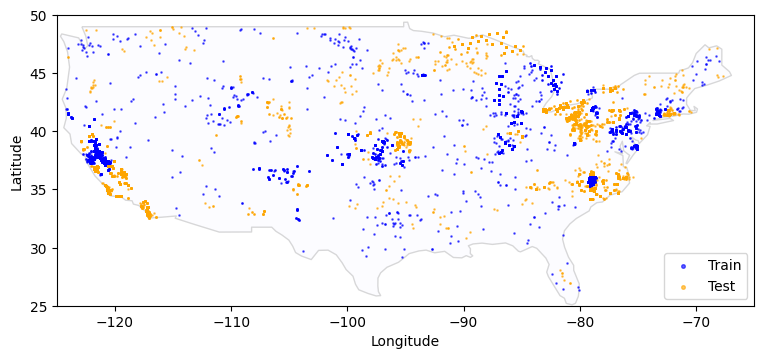

In [13]:
fig, ax = plt.subplots(figsize=(9, 4))

# map the training data
base = world[world.name == "United States of America"].plot(
    edgecolor="gray", color="ghostwhite", figsize=(9, 4), alpha=0.3, ax=ax
)
train_meta = metadata[metadata["split"] == "train"]
geometry = [Point(xy) for xy in zip(train_meta["longitude"], train_meta["latitude"])]
gdf = gpd.GeoDataFrame(train_meta, geometry=geometry)
gdf.plot(ax=base, marker=".", markersize=3, color="blue", label="Train", alpha=0.6)

# map the test data
test_meta = metadata[metadata["split"] == "test"]
geometry = [Point(xy) for xy in zip(test_meta["longitude"], test_meta["latitude"])]
gdf = gpd.GeoDataFrame(test_meta, geometry=geometry)
gdf.plot(ax=base, marker=".", markersize=3, color="orange", label="Test", alpha=0.6)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim([-125, -65])
plt.ylim([25, 50])
plt.legend(loc=4, markerscale=3)
plt.show()

In [14]:
# convert date to pd.datetime
metadata.date = pd.to_datetime(metadata.date)

# what is the date range?
metadata.groupby("split").agg(min_date=("date", min), max_date=("date", max))

,min_date,max_date
split,,
test,2013-01-08,2021-12-29
train,2013-01-04,2021-12-14


In [15]:
# # what years are in the data?
# pd.crosstab(metadata.date.dt.year, metadata.split).plot(kind="bar")
# plt.ylabel("Number of samples")
# plt.xlabel("Year")
# plt.title("Distribution of years in the data")
# plt.show()

In [16]:
# what seasons are the data points from?
metadata["season"] = (
    metadata.date.dt.month.replace([12, 1, 2], "winter")
    .replace([3, 4, 5], "spring")
    .replace([6, 7, 8], "summer")
    .replace([9, 10, 11], "fall")
)
metadata.season.value_counts()

summer    10813
spring     5045
fall       4758
winter     2954
Name: season, dtype: int64

In [17]:
# # where is data from for each season?
# fig, axes = plt.subplots(2, 2, figsize=(10, 5))

# for season, ax in zip(metadata.season.unique(), axes.flatten()):
#     base = world[world.name == "United States of America"].plot(
#         edgecolor="gray", color="ghostwhite", alpha=0.3, ax=ax
#     )

#     sub = metadata[metadata.season == season]
#     geometry = [Point(xy) for xy in zip(sub["longitude"], sub["latitude"])]
#     gdf = gpd.GeoDataFrame(sub, geometry=geometry)
#     gdf.plot(ax=base, marker=".", markersize=2.5)
#     ax.set_xlim([-125, -66])
#     ax.set_ylim([25, 50])
#     ax.set_title(f"{season.capitalize()} data points")
#     ax.axis("off")

In [18]:
train_labels = pd.read_csv(DATA_DIR + "train_labels.csv")
train_labels.head()

,uid,region,severity,density
0,aabm,midwest,1,585.0
1,aacd,south,1,290.0
2,aaee,south,1,1614.0
3,aaff,midwest,3,111825.0
4,aafl,midwest,4,2017313.0


In [19]:
train_labels_and_metadata = train_labels.merge(
    metadata, how="left", left_on="uid", right_on="uid", validate="1:1"
)

Text(0.5, 1.0, 'Train labels severity level counts')

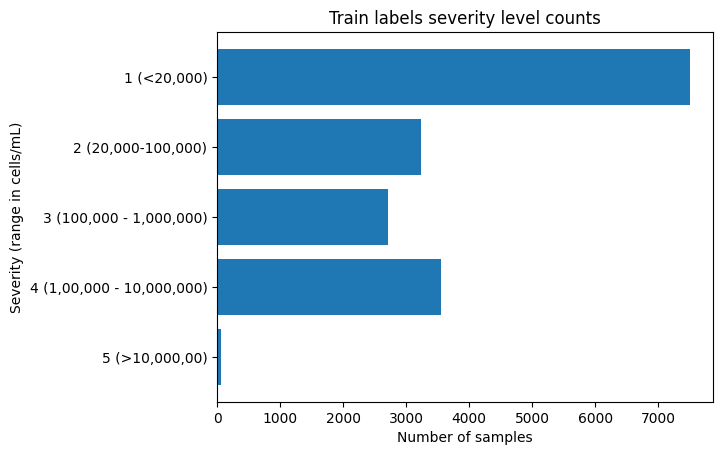

In [20]:
severity_counts = (
    train_labels.replace(
        {
            "severity": {
                1: "1 (<20,000)",
                2: "2 (20,000-100,000)",
                3: "3 (100,000 - 1,000,000)",
                4: "4 (1,00,000 - 10,000,000)",
                5: "5 (>10,000,00)",
            }
        }
    )
    .severity.value_counts()
    .sort_index(ascending=False)
)
plt.barh(severity_counts.index, severity_counts.values)
plt.xlabel("Number of samples")
plt.ylabel("Severity (range in cells/mL)")
plt.title("Train labels severity level counts")

In [21]:
# train_labels.density.describe()

In [22]:
# (train_labels.density == 0).sum()

In [23]:
submission_format = pd.read_csv(DATA_DIR + "submission_format.csv", index_col=0)
submission_format.head()

,region,severity
uid,,
aabn,west,1
aair,west,1
aajw,northeast,1
aalr,midwest,1
aalw,west,1


In [24]:
submission_format.shape

(6510, 2)

In [25]:
# Establish a connection to the STAC API
import planetary_computer as pc
from pystac_client import Client

catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1", modifier=pc.sign_inplace
)

In [26]:
grand_canyon = [-112.15, 36.05]
search = catalog.search(
    collections=["cop-dem-glo-30"],
    intersects={"type": "Point", "coordinates": grand_canyon},
)
items = list(search.get_items())

In [27]:
import planetary_computer
import rioxarray

signed_asset = planetary_computer.sign(items[0].assets["data"])
data = (
    rioxarray.open_rasterio(signed_asset.href)
    .squeeze()
    .drop("band")
    .coarsen({"y": 1, "x": 1})
#     .coarsen({"y": 5, "x": 5})
    .mean()
)


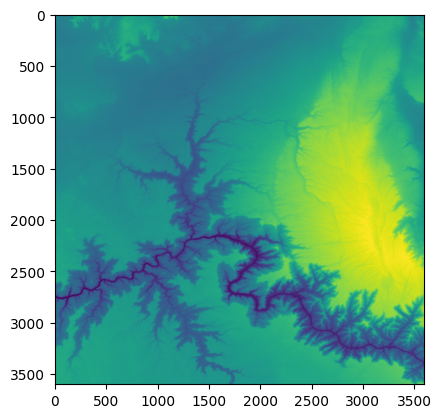

In [28]:
plt.imshow(data)
plt.show()

In [29]:
bbox = get_bounding_box(36.05, -112.15, meter_buffer=20000)
bbox

[-112.37195859885973,
 35.86975203576864,
 -111.92804140114028,
 36.23024253341491]

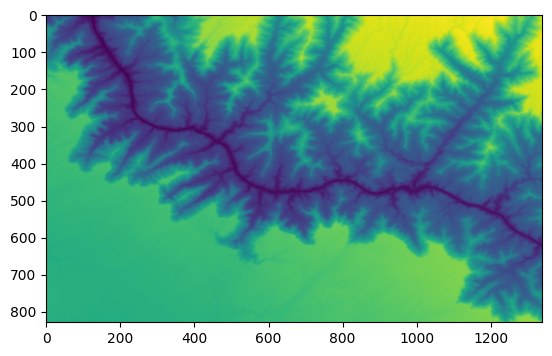

((829, 1339),
 <xarray.DataArray ()>
 array(1289.7324, dtype=float32)
 Coordinates:
     x            float64 -112.2
     y            float64 36.12
     spatial_ref  int64 0
 Attributes:
     AREA_OR_POINT:  Point
     scale_factor:   1.0
     add_offset:     0.0)

In [30]:
(minx, miny, maxx, maxy) = bbox
image = data.rio.clip_box(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        crs="EPSG:4326",
    )
plt.imshow(image)
plt.show()
image.shape,image[int(image.shape[0]/2),int(image.shape[1]/2)]

In [31]:
imc=image.to_numpy().copy()
imc=cv2.resize(imc, (int(imc.shape[1]/5),int(imc.shape[0]/5)))
image.shape,imc.shape

((829, 1339), (165, 267))

In [32]:
np.where(data.x==-112.15),np.where(data.y==36.05),data[np.where(data.y==36.05)[0][0],np.where(data.x==-112.15)[0][0]]


((array([3060]),),
 (array([3420]),),
 <xarray.DataArray ()>
 array(2069.6807, dtype=float32)
 Coordinates:
     x            float64 -112.2
     y            float64 36.05
     spatial_ref  int64 0
 Attributes:
     AREA_OR_POINT:  Point
     scale_factor:   1.0
     add_offset:     0.0)

In [33]:
metadata['latlong']=metadata['latitude'].round(2).astype(str)+'_'+metadata['longitude'].round(2).astype(str)
unique_points=np.unique(metadata.latlong)
metadata.head()

,uid,latitude,longitude,date,split,season,latlong
0,aabm,39.080319,-86.430867,2018-05-14,train,spring,39.08_-86.43
1,aabn,36.559700,-121.510000,2016-08-31,test,summer,36.56_-121.51
2,aacd,35.875083,-78.878434,2020-11-19,train,fall,35.88_-78.88
3,aaee,35.487000,-79.062133,2016-08-24,train,summer,35.49_-79.06
4,aaff,38.049471,-99.827001,2019-07-23,train,summer,38.05_-99.83


In [34]:
distance_search = distance.distance(meters=1000)

# calculate the lat/long bounds based on ground distance
# bearings are cardinal directions to move (south, west, north, and east)
distance_search.destination((39.080319,-86.430867), bearing=180)[0]

39.071311364712614

In [35]:
len(metadata),len(unique_points)

(23570, 2680)

In [36]:
lat,long=unique_points[0].split('_')
lat=float(lat)
long=float(long)
unique_points[0],lat,long

('26.39_-80.11', 26.39, -80.11)

In [44]:
# IMAGE_ARRAY_DIR='benchmark/dem/'
# ind=15
# lat,long=unique_points[ind].split('_')
# lat=float(lat)
# long=float(long)


# ## QUERY STAC API
# # search the planetary computer
# search = catalog.search(
#     collections=["cop-dem-glo-30"],
#     intersects={"type": "Point", "coordinates": [long, lat]},
# )
# items = list(search.get_items())

# signed_asset = planetary_computer.sign(items[0].assets["data"])
# data = (
#     rioxarray.open_rasterio(signed_asset.href)
#     .squeeze()
#     .drop("band")
#     .coarsen({"y": 1, "x": 1})
#     .mean()
# )
# try:
#     altitude=int(data[np.where(data.y==np.round(lat,2))[0][0],np.where(data.x==np.round(long,2))[0][0]]) #valid only for coarsen=1
# except:
#     altitude=-999
# print(altitude)
# # Crop
# bbox = get_bounding_box(lat, long, meter_buffer=20000)
# (minx, miny, maxx, maxy) = bbox
# image = data.rio.clip_box(
#         minx=minx,
#         miny=miny,
#         maxx=maxx,
#         maxy=maxy,
#         crs="EPSG:4326",
#     )

# imc=image.to_numpy().copy()
# #scale image
# imc=cv2.resize(imc, (int(imc.shape[1]/5),int(imc.shape[0]/5)))
# imc=(((imc-imc.min())/(imc.max()-imc.min()))*255).astype('uint8')
# #     image=(((image-image.min())/(image.max()-image.min()))*255).astype('uint8').to_numpy()
# #write image to disk
# cv2.imwrite(IMAGE_ARRAY_DIR+unique_points[ind]+'.jpg',imc)
# d={}
# d[unique_points[ind]]=altitude
# d

In [45]:
# int(data[np.where(data.y==np.round(lat,2))[0][0],np.where(data.x==np.round(long,2))[0][0]])

In [46]:
# np.round(lat,4)

In [47]:
# plt.imshow(imc)
# plt.show()

In [48]:
# meter_buffer=20000

# IMAGE_ARRAY_DIR='benchmark/dem/'
# import os
# isExist = os.path.exists(IMAGE_ARRAY_DIR)
# if not isExist:
#    # Create a new directory because it does not exist
#    os.makedirs(IMAGE_ARRAY_DIR)
    
# def single_query_dem(ind):
#     lat,long=unique_points[ind].split('_')
#     lat=float(lat)
#     long=float(long)
    

#     ## QUERY STAC API
#     # search the planetary computer
#     search = catalog.search(
#         collections=["cop-dem-glo-30"],
#         intersects={"type": "Point", "coordinates": [long, lat]},
#     )
#     items = list(search.get_items())

#     signed_asset = planetary_computer.sign(items[0].assets["data"])
#     data = (
#         rioxarray.open_rasterio(signed_asset.href)
#         .squeeze()
#         .drop("band")
#         .coarsen({"y": 1, "x": 1})
#         .mean()
#     )
#     try:
#         altitude=int(data[np.where(data.y==np.round(lat,2))[0][0],np.where(data.x==np.round(long,2))[0][0]]) #valid only for coarsen=1
#     except:
#         altitude=-999
    
#     # Crop
#     bbox = get_bounding_box(lat, long, meter_buffer=20000)
#     (minx, miny, maxx, maxy) = bbox
#     image = data.rio.clip_box(
#             minx=minx,
#             miny=miny,
#             maxx=maxx,
#             maxy=maxy,
#             crs="EPSG:4326",
#         )
    
#     imc=image.to_numpy().copy()
#     #scale image
#     imc=cv2.resize(imc, (int(imc.shape[1]/5),int(imc.shape[0]/5)))
#     imc=(((imc-imc.min())/(imc.max()-imc.min()))*255).astype('uint8')
# #     image=(((image-image.min())/(image.max()-image.min()))*255).astype('uint8').to_numpy()
#     #write image to disk
#     cv2.imwrite(IMAGE_ARRAY_DIR+unique_points[ind]+'.jpg',imc)
    
#     d={}
#     d[unique_points[ind]]=altitude
#     print(d)
#     return d

# pool = Pool(processes=8)
# for _ in tqdm(pool.imap_unordered(single_query_dem, np.arange(len(unique_points))), total=len(unique_points)):
#     pass

In [49]:
metadata.head()

,uid,latitude,longitude,date,split,season,latlong
0,aabm,39.080319,-86.430867,2018-05-14,train,spring,39.08_-86.43
1,aabn,36.559700,-121.510000,2016-08-31,test,summer,36.56_-121.51
2,aacd,35.875083,-78.878434,2020-11-19,train,fall,35.88_-78.88
3,aaee,35.487000,-79.062133,2016-08-24,train,summer,35.49_-79.06
4,aaff,38.049471,-99.827001,2019-07-23,train,summer,38.05_-99.83


In [50]:
metadata.loc[metadata.uid=='aabm','longitude'].values[0]

-86.4308666666667

In [51]:
# meter_buffer=2000


IMAGE_ARRAY_DIR='benchmark/dem2K/'
import os
isExist = os.path.exists(IMAGE_ARRAY_DIR)
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(IMAGE_ARRAY_DIR)
    
def single_query_dem(uid):
#     lat,long=unique_points[ind].split('_')
#     lat=float(lat)
#     long=float(long)
    lat=metadata.loc[metadata.uid==uid,'latitude'].values[0]
    long=metadata.loc[metadata.uid==uid,'longitude'].values[0]
    

    ## QUERY STAC API
    # search the planetary computer
    search = catalog.search(
        collections=["cop-dem-glo-30"],
        intersects={"type": "Point", "coordinates": [long, lat]},
    )
    items = list(search.get_items())

    signed_asset = planetary_computer.sign(items[0].assets["data"])
    data = (
        rioxarray.open_rasterio(signed_asset.href)
        .squeeze()
        .drop("band")
        .coarsen({"y": 1, "x": 1})
        .mean()
    )
    try:
        altitude=int(data[np.where(data.y==np.round(lat,2))[0][0],np.where(data.x==np.round(long,2))[0][0]]) #valid only for coarsen=1
    except:
        altitude=-999
    
    # Crop
    bbox = get_bounding_box(lat, long, meter_buffer=2000)
    (minx, miny, maxx, maxy) = bbox
    image = data.rio.clip_box(
            minx=minx,
            miny=miny,
            maxx=maxx,
            maxy=maxy,
            crs="EPSG:4326",
        )
    
    imc=image.to_numpy().copy()
    #scale image
    imc=cv2.resize(imc, (int(imc.shape[1]/5),int(imc.shape[0]/5)))
    imc=(((imc-imc.min())/(imc.max()-imc.min()))*255).astype('uint8')
#     image=(((image-image.min())/(image.max()-image.min()))*255).astype('uint8').to_numpy()
    #write image to disk
    cv2.imwrite(IMAGE_ARRAY_DIR+uid+'_alt'+str(altitude)+'.jpg',imc)
#     cv2.imwrite(IMAGE_ARRAY_DIR+unique_points[ind]+'.jpg',imc)
    
    d={}
    d[uid]=altitude
#     d[unique_points[ind]]=altitude
    print(d)
    return d

pool = Pool(processes=8)
for _ in tqdm(pool.imap_unordered(single_query_dem, metadata.uid.values), total=len(metadata.uid.values)):
# for _ in tqdm(pool.imap_unordered(single_query_dem, np.arange(len(unique_points))), total=len(unique_points)):
    pass